In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration

from utils.deconv import richardson_lucy_deblur, richardson_lucy_deblur_blind, L0_deblur
from utils.wrap_boundary import wrap_boundary_liu
from utils.util import PSNR

### Test Input

(600, 800, 3)


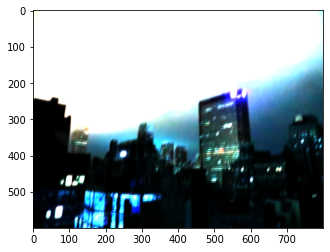

In [3]:
img = cv2.imread("../data/low-illumination/blur_images/saturated_img1_1_blur.png")
img = img / 255.
# gamma correct
img = np.float_power(img, 2.2)

print(img.shape)
plt.imshow(img)

### Test wrapping boundary

(619, 819, 3)


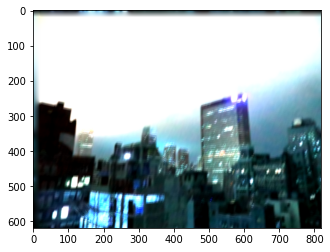

In [3]:
old_h, old_w, old_c = img.shape
K_h = K_w = 20
img_wrap = wrap_boundary_liu(img, (old_h+K_h-1, old_w+K_w-1))

print(img_wrap.shape)
plt.imshow(img_wrap)

In [4]:
# extend boundaries only at top and left
# check similarity

from utils.util import *

tmp = img_wrap[19:, 19:]
print(image_pixel_similarity(tmp, img, tol = 1e-5))

1.0


(604, 804, 3)


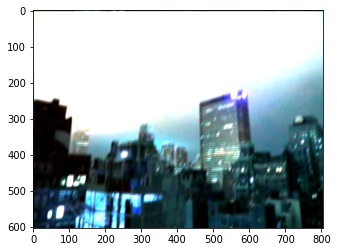

In [5]:
import cv2
from utils.wrap_boundary import wrap_boundary_liu

scale = 2
img_L = img
w, h = img.shape[:2]

img_L = cv2.resize(img, (scale*h, scale*w), interpolation=cv2.INTER_NEAREST)
img_L = wrap_boundary_liu(img_L, [int(np.ceil(scale*w/4+2)*4), int(np.ceil(scale*h/4+2)*4)])
img_wrap = img_L[::scale, ::scale, :]
img_wrap = np.clip(img_wrap, 0., 1.)

print(img_wrap.shape)
plt.imshow(img_wrap)

In [6]:
# extend boundaries only at top and left
# check similarity

from utils.util import *

tmp = img_wrap[4:, 4:]
print(image_pixel_similarity(tmp, img, tol = 1e-5))

1.0


### Test Fourier

In [7]:
from utils.fourier import psf2otf, otf2psf

M = np.array([
    [1,2,3],
    [1,3,2],
    [3,2,1]
])

M_fft = psf2otf(M)
print(M_fft)
M_ = otf2psf(M_fft)
print(M_)

[[18. +0.j         1.5-0.8660254j  1.5+0.8660254j]
 [ 0. +0.j         4.5-0.8660254j -1.5+0.8660254j]
 [ 0. +0.j        -1.5-0.8660254j  4.5+0.8660254j]]
[[1. 2. 3.]
 [1. 3. 2.]
 [3. 2. 1.]]


In [8]:
nabla_x = np.array([1, -1])
nabla_y = np.array([[1], [-1]])

nabla_x_fft = psf2otf(nabla_x, (3, 3))
print(nabla_x_fft)
nabla_y_fft = psf2otf(nabla_y, (3, 3))
print(nabla_y_fft)

nabla_x_ = otf2psf(nabla_x_fft, (1, 2))
print(nabla_x_)
nabla_y_ = otf2psf(nabla_y_fft, (2, 1))
print(nabla_y_)

[[ 0. +0.j        -1.5+0.8660254j -1.5-0.8660254j]
 [ 0. +0.j        -1.5+0.8660254j -1.5-0.8660254j]
 [ 0. +0.j        -1.5+0.8660254j -1.5-0.8660254j]]
[[ 0. +0.j         0. +0.j         0. +0.j       ]
 [-1.5+0.8660254j -1.5+0.8660254j -1.5+0.8660254j]
 [-1.5-0.8660254j -1.5-0.8660254j -1.5-0.8660254j]]
[[ 1. -1.]]
[[ 1.]
 [-1.]]


### Test Richardson Lucy Deblurring

Blurred PSNR: 24.86
Recovered PSNR: 21.30


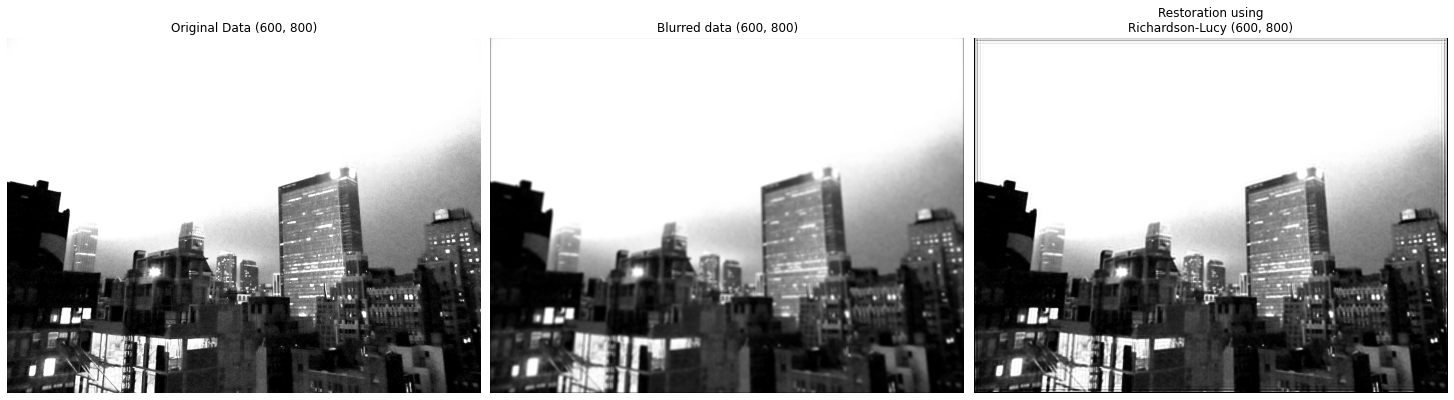

In [4]:
rng = np.random.default_rng()

img = cv2.imread("../data/low-illumination/gt_images/saturated_img1.png", cv2.IMREAD_GRAYSCALE) / 255.

# apply blur kernel
psf = np.ones((5, 5)) / 25.0
img_blur = conv2(img, psf, 'same')

# # Add Noise to Image
# img_noisy = img.copy()
# img_noisy += (rng.poisson(lam=25, size=img.shape) - 10) / 255.

# # Restore Image using Richardson-Lucy algorithm
# deconvolved_RL = restoration.richardson_lucy(img_noisy, psf, num_iter=300)
img_recover = richardson_lucy_deblur(img_blur, psf, num_iter = 25)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title(f'Original Data {img.shape}')

ax[1].imshow(img_blur)
ax[1].set_title(f'Blurred data {img_blur.shape}')

ax[2].imshow(img_recover)
ax[2].set_title(f'Restoration using\nRichardson-Lucy {img_recover.shape}')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

print(f"Blurred PSNR: {PSNR(img, img_blur):.2f}")
print(f"Recovered PSNR: {PSNR(img, img_recover):.2f}")
plt.show()

Blurred PSNR: 24.94
Recovered PSNR: 29.73


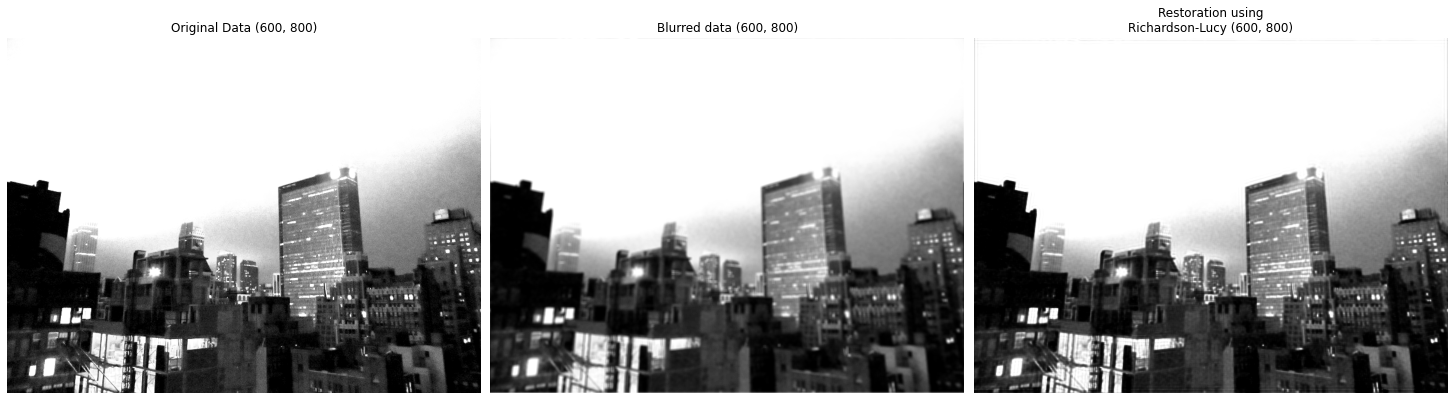

In [5]:
rng = np.random.default_rng()

img = cv2.imread("../data/low-illumination/gt_images/saturated_img1.png", cv2.IMREAD_GRAYSCALE) / 255.

# wrap bounadry for removing artifacts
wrap_size = 10
img_reflect = cv2.copyMakeBorder(img,wrap_size,wrap_size,wrap_size,wrap_size,cv2.BORDER_WRAP)
# img_reflect = cv2.copyMakeBorder(img,wrap_size,wrap_size,wrap_size,wrap_size,cv2.BORDER_REFLECT_101)

# apply blur kernel
psf = np.ones((5, 5)) / 25.0
img_blur = conv2(img_reflect, psf, 'same')

# # Add Noise to Image
# img_noisy = img.copy()
# img_noisy += (rng.poisson(lam=25, size=img.shape) - 10) / 255.

# # Restore Image using Richardson-Lucy algorithm
# deconvolved_RL = restoration.richardson_lucy(img_noisy, psf, num_iter=300)
img_recover = richardson_lucy_deblur(img_blur, psf, num_iter = 25)

# crop the padded boundary
img_recover = img_recover[wrap_size: -wrap_size, wrap_size: -wrap_size]


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title(f'Original Data {img.shape}')

ax[1].imshow(img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size])
ax[1].set_title(f'Blurred data {img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size].shape}')

ax[2].imshow(img_recover)
ax[2].set_title(f'Restoration using\nRichardson-Lucy {img_recover.shape}')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

print(f"Blurred PSNR: {PSNR(img, img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size]):.2f}")
print(f"Recovered PSNR: {PSNR(img, img_recover):.2f}")
plt.show()

Blurred PSNR: 25.69
Recovered PSNR: 23.39


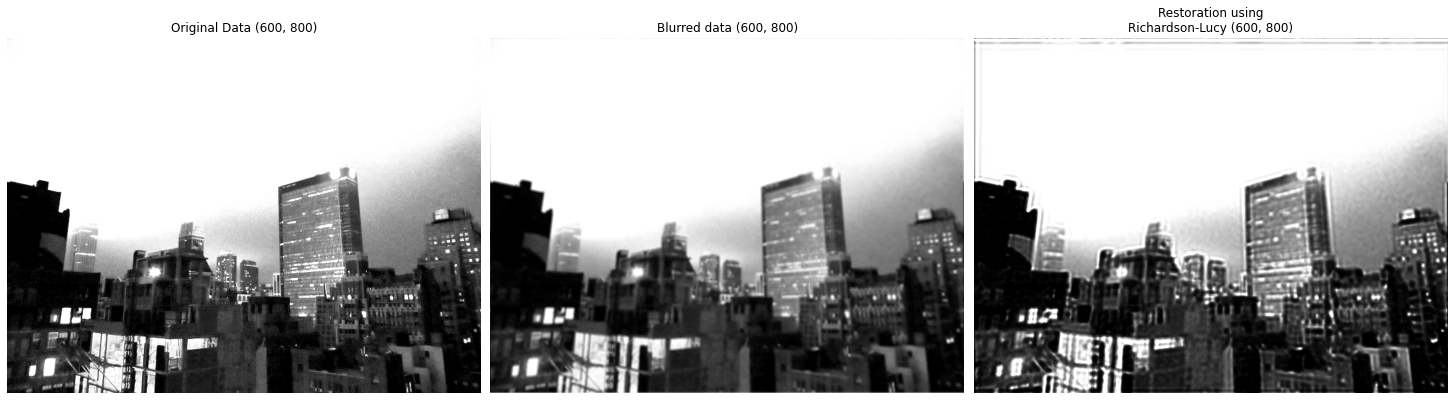

In [22]:
rng = np.random.default_rng()

img = cv2.imread("../data/low-illumination/gt_images/saturated_img1.png", cv2.IMREAD_GRAYSCALE) / 255.

# wrap bounadry for removing artifacts
wrap_size = 10
img_reflect = cv2.copyMakeBorder(img,wrap_size,wrap_size,wrap_size,wrap_size,cv2.BORDER_WRAP)
# img_reflect = cv2.copyMakeBorder(img,wrap_size,wrap_size,wrap_size,wrap_size,cv2.BORDER_REFLECT_101)

# apply blur kernel
np.random.seed(0)
psf = np.random.rand(5,5)
psf = psf / np.sum(psf)
img_blur = conv2(img_reflect, psf, 'same')

# blur kernel init
psf_init = np.ones((9, 9))
psf_init = psf_init / np.sum(psf_init)

# # Add Noise to Image
# img_noisy = img.copy()
# img_noisy += (rng.poisson(lam=25, size=img.shape) - 10) / 255.

# # Restore Image using Richardson-Lucy algorithm
# deconvolved_RL = restoration.richardson_lucy(img_noisy, psf, num_iter=300)
img_recover, psf_estimate = richardson_lucy_deblur_blind(img_blur, psf_init, num_iter = 10)
# crop the padded boundary
img_recover = img_recover[wrap_size: -wrap_size, wrap_size: -wrap_size]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(img)
ax[0].set_title(f'Original Data {img.shape}')

ax[1].imshow(img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size])
ax[1].set_title(f'Blurred data {img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size].shape}')

ax[2].imshow(img_recover)
ax[2].set_title(f'Restoration using\nRichardson-Lucy {img_recover.shape}')

fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)

print(f"Blurred PSNR: {PSNR(img[40:-40, 40:-40], img_blur[wrap_size: -wrap_size, wrap_size: -wrap_size][40:-40, 40:-40]):.2f}")
print(f"Recovered PSNR: {PSNR(img[40:-40, 40:-40], img_recover[40:-40, 40:-40]):.2f}")
plt.show()

### Camera Example

In [3]:
from skimage import img_as_float, data, restoration
camera = img_as_float(data.camera())
from scipy.signal import convolve2d
psf = np.ones((5, 5)) / 25
camera = convolve2d(camera, psf, 'same')
rng = np.random.default_rng()
camera += 0.1 * camera.std() * rng.standard_normal(camera.shape)
deconvolved = restoration.richardson_lucy(camera, psf, 5)

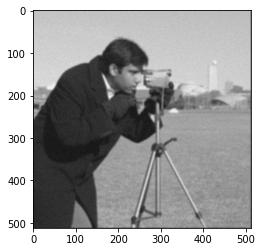

In [4]:
plt.imshow(camera)

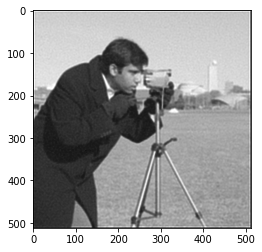

In [5]:
plt.imshow(deconvolved)